## Oceanbolt Python SDK Lesson 5: Exploring correlation of freight prices and indicators

In recent weeks dry bulk rates have rallied and attracted the World's attention. Most of the articles written on this topic explore the underlying causes for the rally. In this Python Lesson, we explore which freight indicators are correlated to the price development. We use some of the freight indicators that are available via the Oceanbolt Data Platform, e.g. fleet utilization, volume exported, congestion, fleet speed, port calls.

As a proxy for freight prices, we use the Breakwave Dry Bulk Shipping ETF. This should serve as a great proxy given its description "BDRY™ provides long exposure to the dry bulk shipping market through a portfolio of near-dated freight futures contracts on dry bulk indices" (source: https://etfmg.com/funds/bdry/). Using the BDRY price as a proxy for freight prices has the advantage that it is available via the Yahoo Finance API.


Make sure to read the corresponding blog post to this Python Lesson, it contains additional context: https://www.oceanbolt.com/blog/oceanbolt_python_sdk_correlation

We have a lot of work ahead of use - Let us get started!

### Step 1 - Setup
Import the relevant libraries (yes, we need a lot ..) and connect to the Oceanbolt API

In [1]:
# Import the relevant libraries (you might need to install some of these)

from oceanbolt.sdk.client import APIClient
from oceanbolt.sdk.data.tonnage import TonnageZoneTimeseries
from oceanbolt.sdk.data.tonnage import FleetSpeedTimeseries
from oceanbolt.sdk.data.port_calls import PortCallTimeseries
from oceanbolt.sdk.data.trade_flows import TradeFlowTimeseries
from oceanbolt.sdk.data.congestion import CongestionTimeseries
from oceanbolt.sdk.data.entities import Regions
from datetime import date
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
# Create the base API client using your token. Tokens can be created in the Oceanbolt App (app.oceanbolt.com)
base_client = APIClient("<token>")

In [3]:
# Connect to the relevant Oceanbolt data endpoints using the base client object, ie: TonnageZoneTimeseries
tonnage_zone_client = TonnageZoneTimeseries(base_client)

### Step 2 - Get the BDRY pricing data from Yahoo Finance's API

As discussed, we use the Yahoo Finance API to get our freight price proxy through the Breakwave Dry Bulk Shipping ETF (BDRY) 

In [4]:
# Set up up the ticker for Breakwave Dry Bulk Shipping ETF (BDRY) 
BDRY = yf.Ticker("BDRY")

In [5]:
# Set up up the ticker for Breakwave Dry Bulk Shipping ETF (BDRY) to get historical pricing
hist = BDRY.history(period="max")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-03-22,25.400000,25.719999,25.360001,25.513000,5400,0,0
2018-03-23,25.520000,25.520000,24.101000,24.101000,205000,0,0
2018-03-26,24.350000,24.850000,24.350000,24.840000,102400,0,0
2018-03-27,24.650000,24.650000,23.459999,24.080000,8500,0,0
2018-03-28,23.900000,23.900000,23.100000,23.379999,2200,0,0
...,...,...,...,...,...,...,...
2021-05-06,24.889999,24.920000,23.290001,23.559999,1408400,0,0
2021-05-07,25.500000,26.110001,25.180000,25.900000,640900,0,0
2021-05-10,27.500000,27.740000,27.051001,27.590000,1143200,0,0


<AxesSubplot:xlabel='Date'>

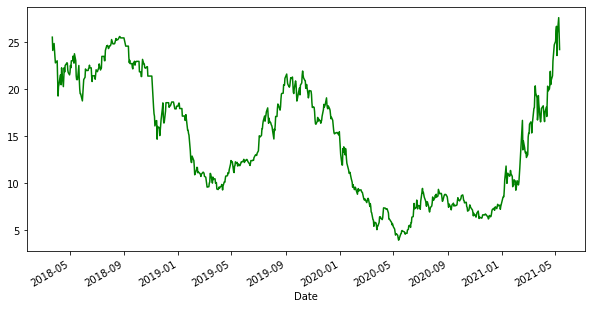

In [6]:
# Let us quickly plot the closing price to visualize the data
hist['Close'].plot(figsize=(10,5), legend=False, color='green')

Certainly, it does look like this ETF has captured the recent rally in dry bulk freight rates.

### Step 3 - Get fleet tilization

We start by taking a look at how dry bulk fleet utilization correlates to the BDRY price. 

We construct the fleet utilization by doing a global vessel count using the "Employed Vessels" methodology as described in Oceanbolt Python SDK Lesson 1 (https://www.oceanbolt.com/blog/oceanbolt_python_sdk_fleet_utilization/) 

In [7]:
# We start by getting the total dry bulk tonnage on a daily basis
total_tonnage = tonnage_zone_client.get(
    start_date=date(2018, 3, 22), 
    end_date=date(2021, 5, 12),  
)

In [8]:
# Then we get the ballasters at sea, making the crude assumption that these are not employed
unemployed_tonnage = tonnage_zone_client.get(
    laden_status=["ballast"],
    port_status=["at_sea"],
    start_date=date(2018, 3, 22), 
    end_date=date(2021, 5, 12),  
)

<AxesSubplot:xlabel='date'>

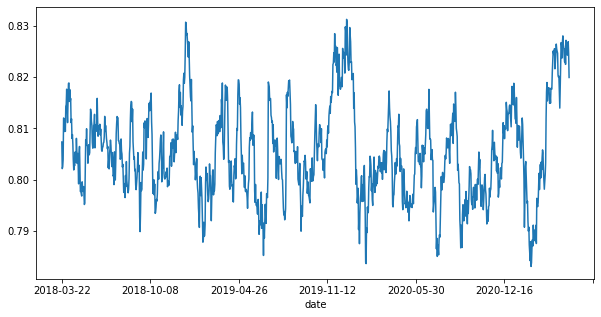

In [9]:
# With this, we calculate the daily utilization for all dry bulk vessels

fleet_utilization = pd.DataFrame(1-unemployed_tonnage['vessel_dwt']/total_tonnage['vessel_dwt'])
fleet_utilization['date'] = total_tonnage['date']
fleet_utilization.plot(x='date', figsize=(10,5), legend=False, )

### Step 4 - Visualize the results in same plot
Let us do a quick double plot to examine the development. While the Breakwave Dry Bulk Shipping ETF (BDRY) is only traded when markets are open, we can get fleet utilization for any day. Therefore, wee need to do a bit a data wrangling to aling the observed dates.

We pick only the days when the ETF is traded.

In [10]:
# Quick wrangling to get the data into shape.

fleet_utilization['date']= pd.to_datetime(fleet_utilization['date']).astype(str)
hist['date'] = hist.index.astype(str)
merged = pd.merge(hist, fleet_utilization, how='left', on='date')

merged.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,vessel_dwt
0,25.40,25.719999,25.360001,25.513000,5400,0,0,2018-03-22,0.807348
1,25.52,25.520000,24.101000,24.101000,205000,0,0,2018-03-23,0.802145
2,24.35,24.850000,24.350000,24.840000,102400,0,0,2018-03-26,0.812033
3,24.65,24.650000,23.459999,24.080000,8500,0,0,2018-03-27,0.811927
4,23.90,23.900000,23.100000,23.379999,2200,0,0,2018-03-28,0.809397


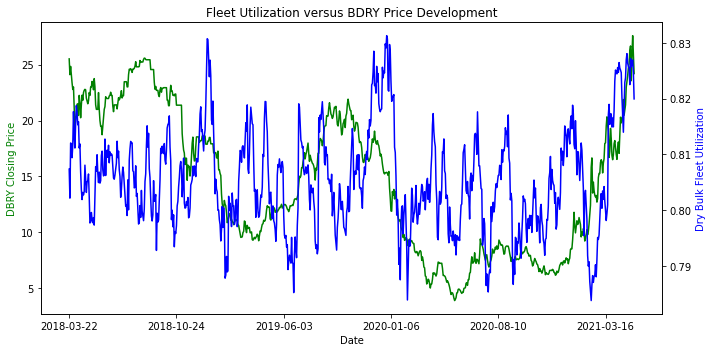

In [11]:
# Let us plot the results

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Fleet Utilization versus BDRY Price Development')

x = merged['date'].to_list() # Date as the x axis
y1 = merged['Close'].to_list() #BDRY Closing Price as the first y axis
y2 = merged['vessel_dwt'].to_list() #Dry bulk fleet utilization as the second y axis
ax2 = ax.twinx()
ax.plot(x, y1, color = 'g')
ax2.plot(x, y2, color = 'b')
ax.set_xlabel('Date')
ax.set_ylabel('DBRY Closing Price', color = 'g')
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
ax2.set_ylabel('Dry Bulk Fleet Utilization', color = 'b')
plt.tight_layout()

plt.show()

### Step 5 - Calculate correlation

In [12]:
r, p = stats.pearsonr(merged['Close'], merged['vessel_dwt'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.2894806325463121 and p-value: 9.79905310359569e-17


Correlation of 0.289 and a highly significant p-value, interesting indeed, but let us see, if other freight indicators can do better.

### Step 6 - Testing other freight variables

We just illustrated how the fleet uilization correlates to the BDRY pricing, but let us test other popular freight indicators to see if we can do better by either of them. Specifically, we will test, fleet speed, volume exported, number of port calls and congestion against BDRY. See the blog post (https://www.oceanbolt.com/blog/oceanbolt_python_sdk_correlation) for a bit of economic reasoning for why we have picked these.  

In [13]:
# Let's get fleet speed
fs_client = FleetSpeedTimeseries(base_client)
fleet_speed = fs_client.get(
    start_date=date(2018, 3, 22), 
    end_date=date(2021, 5, 12),  
)

In [14]:
# Next we get port calls
pc_client = PortCallTimeseries(base_client)
portcalls = pc_client.get(
    start_date=date(2018, 3, 22), 
    end_date=date(2021, 5, 12),
    frequency="daily"
)

In [15]:
# Then volume exported
tf_client = TradeFlowTimeseries(base_client)
trade_flows = tf_client.get(
    start_date=date(2018, 3, 22), 
    end_date=date(2021, 5, 12),
    frequency="daily"
)

In [16]:
# We need to call the congestion endpoint with all regions to get global congestion, we created a complete list of regions by calling our entities endpoint
regions = Regions(base_client).get()
region_list = []
for i in range(len(regions)):
    region_list.append(regions['region_id'][i])

In [17]:
# With the list of regions in place, we call our congestion endpoint to get congestion and construct a % of fleet congested variable by diving the DWT congestion by total DWT
c_client = CongestionTimeseries(base_client)
congestion = c_client.get(
    start_date=date(2018, 3, 22), 
    end_date=date(2021, 5, 12),
    region_id = region_list
)

pct_congested = pd.DataFrame(congestion['vessel_dwt']/total_tonnage['vessel_dwt'])
pct_congested['date'] = total_tonnage['date']

In [18]:
# Once again, to align days where BDRY is traded with our freight indicators, we merge in our freight indicators on days where BDRY is traded
fleet_speed['date']= pd.to_datetime(fleet_speed['date']).astype(str)
merged = pd.merge(merged, fleet_speed, how='left', on='date')
portcalls['date']= pd.to_datetime(portcalls['date']).astype(str)
merged = pd.merge(merged, portcalls, how='left', on='date')
trade_flows['date']= pd.to_datetime(trade_flows['date']).astype(str)
merged = pd.merge(merged, trade_flows, how='left', on='date')
pct_congested['date']= pd.to_datetime(pct_congested['date']).astype(str)
merged = pd.merge(merged, pct_congested, how='left', on='date')
merged

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,vessel_dwt_x,avg_speed,value_x,value_y,vessel_dwt_y
0,25.400000,25.719999,25.360001,25.513000,5400,0,0,2018-03-22,0.807348,11.314603,1292,14899200,0.202995
1,25.520000,25.520000,24.101000,24.101000,205000,0,0,2018-03-23,0.802145,11.351123,1295,16765700,0.199026
2,24.350000,24.850000,24.350000,24.840000,102400,0,0,2018-03-26,0.812033,11.506412,1317,17443600,0.205518
3,24.650000,24.650000,23.459999,24.080000,8500,0,0,2018-03-27,0.811927,11.528576,1335,16807700,0.200884
4,23.900000,23.900000,23.100000,23.379999,2200,0,0,2018-03-28,0.809397,11.533803,1200,18859900,0.204364
...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,24.889999,24.920000,23.290001,23.559999,1408400,0,0,2021-05-06,0.825692,11.658945,1379,17496900,0.228111
787,25.500000,26.110001,25.180000,25.900000,640900,0,0,2021-05-07,0.826575,11.691329,1448,18510300,0.22813
788,27.500000,27.740000,27.051001,27.590000,1143200,0,0,2021-05-10,0.826939,11.661941,1512,18666500,0.235708
789,25.780001,25.990000,25.250000,25.990000,959500,0,0,2021-05-11,0.824594,11.710953,1677,17063200,0.231778


In [19]:
# We drop the variables that we do not need and rename the variables to make sende for our analysis
variables = merged.drop(columns=['Open', 'High','Low', 'Volume','Dividends','Stock Splits','date'])
variables_renamed = variables.rename(columns={'Close': 'BDRY_price', 'vessel_dwt_x': 'fleet_utilization', 'avg_speed': 'fleet_speed','value_x': 'port_calls','value_y': 'volume_exported','vessel_dwt_y':'pct_dwt_congested'})
variables_renamed

,BDRY_price,fleet_utilization,fleet_speed,port_calls,volume_exported,pct_dwt_congested
0,25.513000,0.807348,11.314603,1292,14899200,0.202995
1,24.101000,0.802145,11.351123,1295,16765700,0.199026
2,24.840000,0.812033,11.506412,1317,17443600,0.205518
3,24.080000,0.811927,11.528576,1335,16807700,0.200884
4,23.379999,0.809397,11.533803,1200,18859900,0.204364
...,...,...,...,...,...,...
786,23.559999,0.825692,11.658945,1379,17496900,0.228111
787,25.900000,0.826575,11.691329,1448,18510300,0.22813
788,27.590000,0.826939,11.661941,1512,18666500,0.235708
789,25.990000,0.824594,11.710953,1677,17063200,0.231778


In [20]:
# Let us do a correlation matrix
variables_renamed.corr()

,BDRY_price,fleet_utilization,fleet_speed,port_calls,volume_exported,pct_dwt_congested
BDRY_price,1.000000,0.289481,0.498862,0.360032,0.238809,-0.557641
fleet_utilization,0.289481,1.000000,0.078908,0.261871,0.258921,0.109017
fleet_speed,0.498862,0.078908,1.000000,0.426819,0.272516,-0.262599
port_calls,0.360032,0.261871,0.426819,1.000000,0.296250,-0.217297
volume_exported,0.238809,0.258921,0.272516,0.296250,1.000000,-0.199575
pct_dwt_congested,-0.557641,0.109017,-0.262599,-0.217297,-0.199575,1.000000


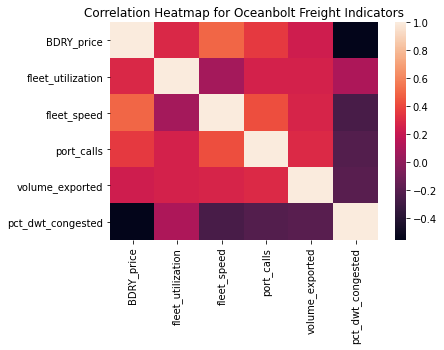

In [21]:
# And plot a heatmap of the results
ax = sns.heatmap(variables_renamed.corr())
plt.title('Correlation Heatmap for Oceanbolt Freight Indicators')
plt.show()

Certainly some indicators exhibit higher correlation with BDRY than fleet utilization.

Thank you for reading this. You can find more information on Oceanbolt and sign up for a demo on our website: https://www.oceanbolt.com/demo/